# Assignment 10 - Data Science in Finance and Insurance
Submission by: Dennis Goldenberg

In [110]:
#import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [111]:
#read in data
hw_data = pd.read_csv("Howell1.csv", sep = ';')

## Part [a]

In [112]:
#Generate explanatory, response variable matrices
X = hw_data[np.where(hw_data['age'] >= 18, True, False)].drop(labels = ['height', 'age'], axis = 1)
y = hw_data['height'][X.index.values]

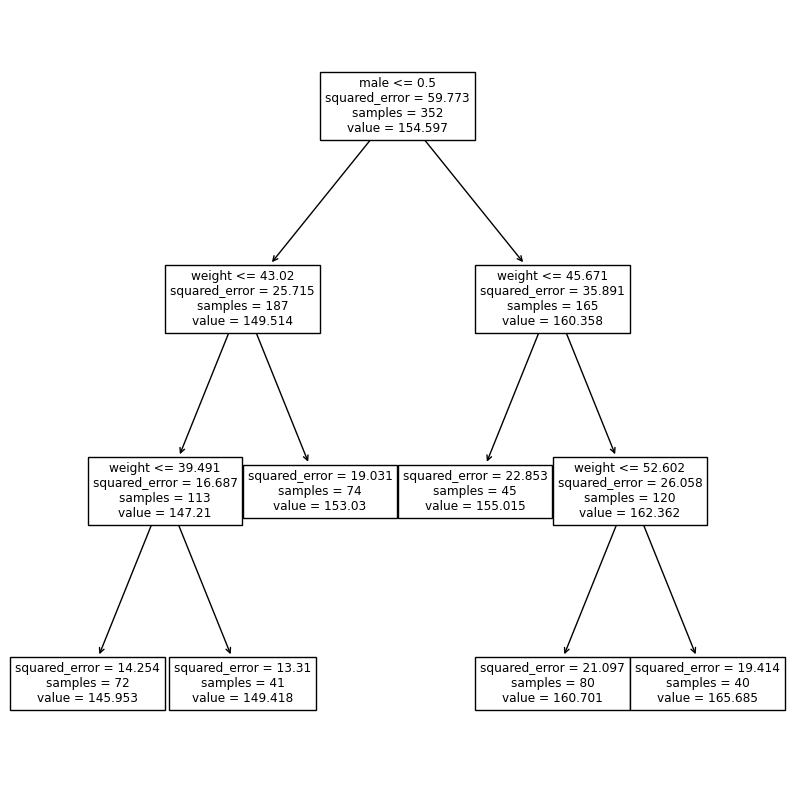

In [113]:
#Fit tree
tree = DecisionTreeRegressor(max_leaf_nodes=6, min_samples_leaf=40).fit(X,y)

#plot tree
plt.figure(figsize = (10,10))
plot_tree(tree, feature_names= X.columns.values)
plt.show()

## Part [b]

In [114]:
#Get samples that are in node 3
X_3 = X[np.where(X['male'] >= 0.5, True, False)]
y_3 = y[X_3.index.values]

### Creating Mean Squared Error Function

In [115]:
#Create MSE function for MSE calculations
def MSE(x_1, x_2):
    return np.matmul((x_1 - x_2).T,(x_1 - x_2))/len(x_1 - x_2)

### Creating Function for all Possible MSE splits
The possible splits (for observations ordered on variable to split on) change when the upper bound to get into node 6 is moved up enough to add the next observation in the order. Thus, I find all possible MSE values by iterating over the unique observation values for said variable.

In [117]:
def split_MSE_possibilities(features, y_vals, split_feature):
    split_vals = np.unique(features['{}'.format(split_feature)].values)
    RSS = []
    mse_nodes = []
    samples = []
    predictions = []
    #Iterate over each potential value and find MSE and RSS at said point
    for val in split_vals:
        X_6 = features[np.where(features['{}'.format(split_feature)].values < val, True, False)]
        X_7 = features.drop(X_6.index.values, axis = 0)
        mse_x6, predictions_x6, mse_x7, predictions_x7 = (0,0,0,0)
        if len(X_6) > 0:
            y_s = y_vals[X_6.index.values].values
            mse_x6 = MSE(y_s, np.mean(y_s))
            predictions_x6 = np.mean(y_s)
        if len(X_7) > 0:
            y_s = y_vals[X_7.index.values].values
            mse_x7 = MSE(y_s, np.mean(y_s))
            predictions_x7 = np.mean(y_s)
        mse_nodes.append((mse_x6, mse_x7))
        samples.append((len(X_6), len(X_7)))
        predictions.append((predictions_x6, predictions_x7))
        RSS.append(mse_x6 * len(X_6) + mse_x7 * len(X_7))
    return split_vals, np.asarray(samples), np.asarray(predictions), np.asarray(mse_nodes), np.asarray(RSS)

### Splitting by Sex
There are only 2 possible values for sex: 0 (female) and 1 (male). Further, in node 3, the only datapoints there are the ones where $sex > 0.5$, which means that all in this group are male. Therefore, the only "split" is where all are in 1 category.

In [118]:
#Find split MSE possibilities when splitting on male
split_val_male, sample_male, prediction_male, mse_male, RSS_male = split_MSE_possibilities(X_3, y_3, 'male')

#Find minimum RSS of possibilities
min_male_index = np.argmin(RSS_male)
min_RSS_male = RSS_male[min_male_index]

### Splitting by Weight

I implement the same method as I did in the previous version; here, since the my MSE possibilities method iterates over the different unique weight values in the sample in node 3, I generate the true optimal cutpoint by taking the average of the point at which the minimum is found and the one before (which does not shift observations between nodes, as I used $<$ when putting values into node 6). In essence:
$$\begin{equation*}
\text{Optimal Cutpoint} = \frac{\text{Observation at Which Minimum RSS found} + \text{Observation before}}{2}
\end{equation*}$$

split node 3 by sex:  cutpoints = male, RSS = 5922.0742

split node 3 by weight: cutpoints = 45.67, RSS = 4155.3382
resulting node 6: mse = 22.8533, samples = 45, prediction = 155.0149
resulting node 7: mse = 26.0578, samples = 120, prediction = 162.3623


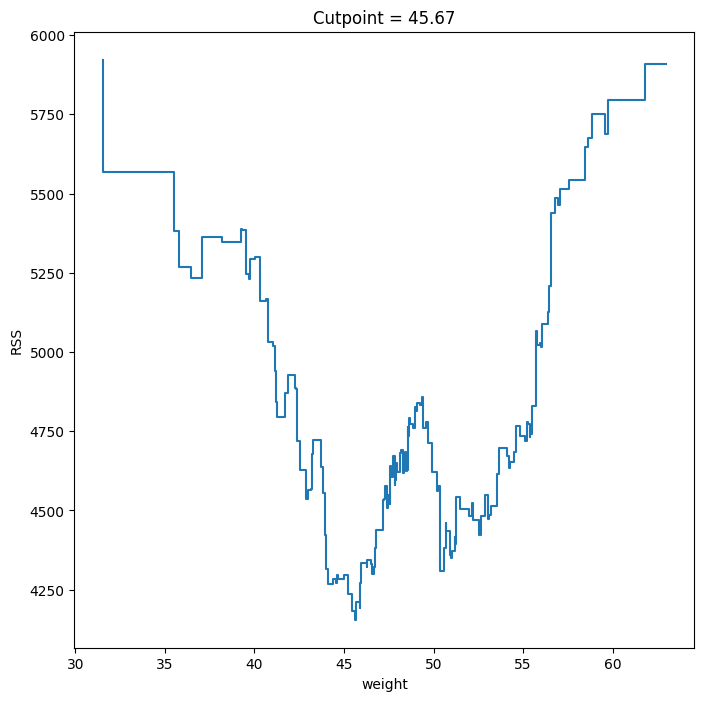

In [119]:
#Run method while cutting on weight
spv_weight, sample_weight, prediction_weight, mse_weight, RSS_weight = split_MSE_possibilities(X_3, y_3, 'weight')

#Get minimum weight index
mwi = np.argmin(RSS_weight)

#Print out requested
print('split node 3 by sex:  cutpoints = {}, RSS = {}'.format('male', RSS_male[min_male_index].round(4)))
owc = round((spv_weight[mwi - 1] + spv_weight[mwi])/2,2)
print('\nsplit node 3 by weight: cutpoints = {}, RSS = {}'.format(owc,RSS_weight[mwi].round(4)))
print('resulting node 6: mse = {}, samples = {}, prediction = {}'\
      .format(mse_weight[mwi][0].round(4), sample_weight[mwi][0], prediction_weight[mwi][0].round(4)))
print('resulting node 7: mse = {}, samples = {}, prediction = {}'\
      .format(mse_weight[mwi][1].round(4), sample_weight[mwi][1], prediction_weight[mwi][1].round(4)))

#Plot graph of RSS vs. cutpoint
plt.figure(figsize = (8,8))
plt.step(spv_weight, RSS_weight)
plt.title('Cutpoint = {}'.format(owc))
plt.ylabel('RSS')
plt.xlabel('weight')
plt.show()